## Signac RDF Function

#### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import freud
import signac
import gsd
import hoomd
import gsd.pygsd
import gsd.hoomd
import scipy
from scipy import signal
import time
import os
import cycler
from scipy.stats import linregress
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import connected_components
import cmeutils
from cmeutils import structure

#### Give a file path to pull the trajectory from

In [3]:
ptb7_path = "/home/gwenwhite/cmelab/projects/ptb7-project/"
ptb7_project = signac.get_project(ptb7_path)

#### Narrow results with state dictionary 

In [11]:
state_dict={"size": "small", 
            "process": "quench",
            "molecule": "PTB7_5mer_smiles",
            "density":0.9,
            "kT_reduced": 1.2}

job_list= ptb7_project.find_jobs(state_dict)
for job in job_list:
    print(job)

9afdb8a280a87c29213b69b7794a5504


#### Create a .txt file of RDF data

In [15]:
def rdf_to_txt(job_list):
    for job in job_list:
        job_path = job.fn('trajectory.gsd')
        A_name = "ss"
        B_name = "ss"
        rdf, norm = structure.gsd_rdf(job_path, A_name, B_name, r_min=0.01, r_max=6)
        '''gsd_utils.gsd_rdf is a function from cme_lab_utils that creates the RDF'''
        x = rdf.bin_centers
        y = rdf.rdf*norm
        filename = job.fn('{}-{}-uncorr-rdf-data.txt'.format(A_name[0], B_name[0]))
        np.savetxt(filename, np.transpose([x,y]), delimiter=',', header= "bin_centers, rdf")
        print(".txt file created for job:")
        print(job)

In [16]:
rdf_to_txt(job_list)

.txt file created for job:
9afdb8a280a87c29213b69b7794a5504


#### specify how txt file can be plotted

In [19]:
def plot_txt(constant="den"): 
    if constant == "den":
        state_dict['density.$lt'] = 1.3
        fig = plt.figure()
        ax = plt.subplot(111)
        color = plt.cm.coolwarm(np.linspace(0, 1, len(job_list)))
        plt.rcParams['axes.prop_cycle'] = cycler.cycler('color', color)
        for kT,job in job_list.groupby('kT_reduced'):
            job = list(job)[0]
            A_name = "ss"
            B_name = "ss"
            txt_path= job.fn('{}-{}-uncorr-rdf-data.txt'.format(A_name[0], B_name[0]))
            line= np.genfromtxt(txt_path, names=True, delimiter=",")
            x= line["bin_centers"]
            y= line["rdf"]
            plt.plot(x, y, label=kT)
            plt.xlabel("r (A.U.)")
            plt.ylabel("g(r)")
            plt.title("%s and %s's at %sden" % (A_name, B_name, job.sp['density']), fontsize=16)
            plt.legend(bbox_to_anchor=(1.5, 1), ncol=2)
    elif constant == "temp":
        state_dict['kT_reduced.$lt'] = 2.5
        fig = plt.figure()
        ax = plt.subplot(111)
        color = plt.cm.coolwarm(np.linspace(0, 1, len(job_list)))
        plt.rcParams['axes.prop_cycle'] = cycler.cycler('color', color)
        for den,job in job_list.groupby('density'):
            job = list(job)[0]
            A_name = "ss"
            B_name = "ss"
            txt_path= job.fn('{}-{}-uncorr-rdf-data.txt'.format(A_name[0], B_name[0]))
            line= np.genfromtxt(txt_path, names=True, delimiter=",")
            x= line["bin_centers"]
            y= line["rdf"]
            plt.plot(x, y, label=den)
            plt.xlabel("r (A.U.)")
            plt.ylabel("g(r)")
            plt.title("%s and %s's at %sden" % (A_name, B_name, job.sp['kT_reduced']), fontsize=16)
            plt.legend(bbox_to_anchor=(1.5, 1), ncol=2)
    elif constant == "both":
        fig = plt.figure()
        ax = plt.subplot(111)
        color = plt.cm.brg(np.linspace(0, 1, len(job_list)))
        plt.rcParams['axes.prop_cycle'] = cycler.cycler('color', color)
        for mer,job in job_list.groupby('molecule'):
            job = list(job)[0]
            A_name = "ss"
            B_name = "ss"
            txt_path= job.fn('{}-{}-uncorr-rdf-data.txt'.format(A_name[0], B_name[0]))
            line= np.genfromtxt(txt_path, names=True, delimiter=",")
            x= line["bin_centers"]
            y= line["rdf"]
            plt.plot(x, y, label=mer)
            plt.xlabel("r (A.U.)")
            plt.ylabel("g(r)")
            plt.title("%s and %s's at %sden %skT" % (A_name, B_name, job.sp['density'], job.sp['kT_reduced']), fontsize=16)
            plt.legend(bbox_to_anchor=(1.5, 1), ncol=2)
        

#### Plot your txt file(s)

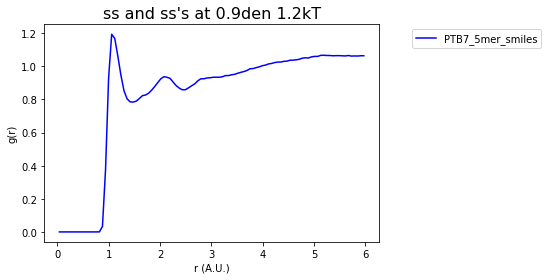

In [20]:
plot_txt(constant="both") #constant= "den" for density, "temp" for temperature, "both" to compare polymer lengths at constant temperature and density